# 1. Import Module & Data

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib import figure
import matplotlib.pyplot as plt
import math
import os
import time
import random
import gc
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
data_folder = '../data/'
os.makedirs(data_folder, exist_ok=True)

df = pd.read_csv(data_folder + 'traffic.csv', header=None)
df = df[1:].astype('float').T

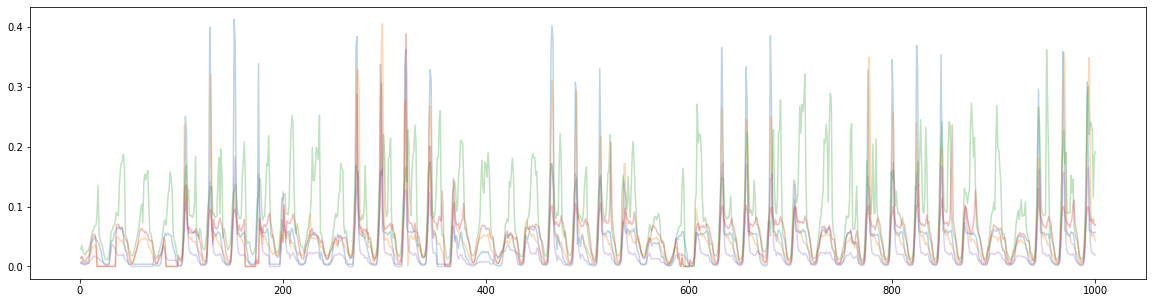

In [4]:
plt.figure(figsize=(20,5))
plt.plot(df.iloc[:5, :1000].T, alpha=.3)
plt.show()

In [5]:
from torch import nn
from torch.utils.data import Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import torch

import os
import statistics
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt

SEED = 10
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

### Special DataLoader for Traffic Data ###

In [6]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch

import numpy as np
def normal_std(x):
    return x.std() * np.sqrt((len(x) - 1.) / (len(x)))

class DataLoaderH(object):
    # train and valid is the ratio of training set and validation set. test = 1 - train - valid
    def __init__(self, file_name, train, valid, horizon, window, pred_step, normalize=2):
        """
        1.Get Data
        2. Normalize 
        3. Split
        """
        self.P = window
        self.h = horizon
        self.pred_step = pred_step
        
        fin = open(file_name)
        self.rawdat = np.loadtxt(fin, delimiter=',')
        self.dat = np.zeros(self.rawdat.shape)

        self.n, self.m = self.dat.shape
        self.normalize = 2
        self.scale = np.ones(self.m)
        self.bias =  np.zeros(self.m)
        self._normalized(normalize)
        self._split(int(train * self.n), int((train + valid) * self.n), self.n)

        self.scale = torch.from_numpy(self.scale).float()
        self.bias = torch.from_numpy(self.bias).float()
        tmp = self.test[1] * self.scale.expand(self.test[1].size(0), self.h, self.m)

        self.scale = self.scale.cuda()
        self.scale = Variable(self.scale)
        self.bias = self.bias.cuda()
        self.bias = Variable(self.bias)

        tmp = tmp[:, -1, :].squeeze()
        self.rse = normal_std(tmp)
        self.rae = torch.mean(torch.abs(tmp - torch.mean(tmp)))

    def _normalized(self, normalize):
        """
        Normalize Data
        0. No Normalization
        1. MinMaxScaler - by one scaler
        2. MinMaxScaler - by each sensor
        3. StandardScaler - by each sensor
        """
        if (normalize == 0):
            self.dat = self.rawdat

        if (normalize == 1):
            # normalized by the maximum value of entire matrix.
            self.dat = self.rawdat / np.max(self.rawdat)
        
        if (normalize == 2):
            # normlized by the maximum value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.max(np.abs(self.rawdat[:, i]))
                self.dat[:, i] = self.rawdat[:, i] / np.max(np.abs(self.rawdat[:, i]))

        if (normalize == 3):
            # normlized by the mean/std value of each row (sensor).
            for i in range(self.m):
                self.scale[i] = np.std(self.rawdat[:, i]) #std
                self.bias[i] = np.mean(self.rawdat[:, i])
                self.dat[:, i] = (self.rawdat[:, i] - self.bias[i]) / self.scale[i]


    def _split(self, train, valid, test):
        """
        Train-Valid-Test Split
        1. Make as Dataset
        2. Make as Loader
        """
        train_set = range(self.P + self.pred_step, train)
        valid_set = range(train, valid)
        test_set = range(valid, self.n)
        self.train = self._batchify(train_set, self.h)
        self.valid = self._batchify(valid_set, self.h)
        self.test = self._batchify(test_set, self.h)

    def _batchify(self, idx_set, horizon):
        n = len(idx_set)
        X = torch.zeros((n, self.P, self.m))
        Y = torch.zeros((n, self.h, self.m))
        for i in range(n):
            end = idx_set[i] - self.pred_step + 1
            start = end - self.P
            X[i, :, :] = torch.from_numpy(self.dat[start:end, :])
            Y[i, :, :] = torch.from_numpy(self.dat[[end+self.pred_step-1], :])
        return [X, Y]

    def get_batches(self, inputs, targets, batch_size, shuffle=True):
        """
        get Batch
        """
        length = len(inputs)
        if shuffle:
            index = torch.randperm(length)
        else:
            index = torch.LongTensor(range(length))
        start_idx = 0
        while (start_idx < length):
            end_idx = min(length, start_idx + batch_size)
            excerpt = index[start_idx:end_idx]
            X = inputs[excerpt]
            Y = targets[excerpt]
            X = X.cuda()
            Y = Y.cuda()
            yield Variable(X), Variable(Y)
            start_idx += batch_size

In [7]:
batch_size = 64
num_workers = 4
pin_memory = True
num_class = 5
device = 'cuda'
num_epoch = 20
lr = 1e-4

In [8]:
train_ratio = 0.6
valid_ratio = 0.2
window = 168
horizon = 1
pred_step = 24
normalize = 2

loader = DataLoaderH(data_folder+'traffic.txt', train_ratio, valid_ratio, horizon, window, pred_step, normalize)

# 2. DynamicRouting CapsNet

In [9]:
result_folder = '../check/drcaps/pred/'
os.makedirs(result_folder, exist_ok=True)

attack_result_folder = '../check/drcaps/pred_attack/'
os.makedirs(attack_result_folder, exist_ok=True)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


def squash(inputs, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param inputs: vectors to be squashed
    :param axis: the axis to squash
    :return: a Tensor with same size as inputs
    """
    norm = torch.norm(inputs, p=2, dim=axis, keepdim=True)
    scale = norm**2 / (1 + norm**2) / (norm + 1e-8)
    return scale * inputs


class DenseCapsule(nn.Module):
    """
    The dense capsule layer. It is similar to Dense (FC) layer. Dense layer has `in_num` inputs, each is a scalar, the
    output of the neuron from the former layer, and it has `out_num` output neurons. DenseCapsule just expands the
    output of the neuron from scalar to vector. So its input size = [None, in_num_caps, in_dim_caps] and output size = \
    [None, out_num_caps, out_dim_caps]. For Dense Layer, in_dim_caps = out_dim_caps = 1.
    :param in_num_caps: number of cpasules inputted to this layer
    :param in_dim_caps: dimension of input capsules
    :param out_num_caps: number of capsules outputted from this layer
    :param out_dim_caps: dimension of output capsules
    :param routings: number of iterations for the routing algorithm
    """
    def __init__(self, in_num_caps, in_dim_caps, out_num_caps, out_dim_caps, routings=3):
        super(DenseCapsule, self).__init__()
        self.in_num_caps = in_num_caps
        self.in_dim_caps = in_dim_caps
        self.out_num_caps = out_num_caps
        self.out_dim_caps = out_dim_caps
        self.routings = routings
        self.weight = nn.Parameter(0.01 * torch.randn(out_num_caps, in_num_caps, out_dim_caps, in_dim_caps))

    def forward(self, x):
        # x.size=[batch, in_num_caps, in_dim_caps]
        # expanded to    [batch, 1,            in_num_caps, in_dim_caps,  1]
        # weight.size   =[       out_num_caps, in_num_caps, out_dim_caps, in_dim_caps]
        # torch.matmul: [out_dim_caps, in_dim_caps] x [in_dim_caps, 1] -> [out_dim_caps, 1]
        # => x_hat.size =[batch, out_num_caps, in_num_caps, out_dim_caps]
        x_hat = torch.squeeze(torch.matmul(self.weight, x[:, None, :, :, None]), dim=-1)

        # In forward pass, `x_hat_detached` = `x_hat`;
        # In backward, no gradient can flow from `x_hat_detached` back to `x_hat`.
        x_hat_detached = x_hat.detach()

        # The prior for coupling coefficient, initialized as zeros.
        # b.size = [batch, out_num_caps, in_num_caps]
        b = Variable(torch.zeros(x.size(0), self.out_num_caps, self.in_num_caps)).cuda()

        assert self.routings > 0, 'The \'routings\' should be > 0.'
        for i in range(self.routings):
            # c.size = [batch, out_num_caps, in_num_caps]
            c = F.softmax(b, dim=1)

            # At last iteration, use `x_hat` to compute `outputs` in order to backpropagate gradient
            if i == self.routings - 1:
                # c.size expanded to [batch, out_num_caps, in_num_caps, 1           ]
                # x_hat.size     =   [batch, out_num_caps, in_num_caps, out_dim_caps]
                # => outputs.size=   [batch, out_num_caps, 1,           out_dim_caps]
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat))  # alternative way
            else:  # Otherwise, use `x_hat_detached` to update `b`. No gradients flow on this path.
                outputs = squash(torch.sum(c[:, :, :, None] * x_hat_detached, dim=-2, keepdim=True))
                # outputs = squash(torch.matmul(c[:, :, None, :], x_hat_detached))  # alternative way

                # outputs.size       =[batch, out_num_caps, 1,           out_dim_caps]
                # x_hat_detached.size=[batch, out_num_caps, in_num_caps, out_dim_caps]
                # => b.size          =[batch, out_num_caps, in_num_caps]
                b = b + torch.sum(outputs * x_hat_detached, dim=-1)

        return torch.squeeze(outputs, dim=-2)


class PrimaryCapsule(nn.Module):
    """
    Apply Conv2D with `out_channels` and then reshape to get capsules
    :param in_channels: input channels
    :param out_channels: output channels
    :param dim_caps: dimension of capsule
    :param kernel_size: kernel size
    :return: output tensor, size=[batch, num_caps, dim_caps]
    """
    def __init__(self, in_channels, out_channels, dim_caps, kernel_size, stride=1, padding=0):
        super(PrimaryCapsule, self).__init__()
        self.dim_caps = dim_caps
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        outputs = self.conv2d(x)
        outputs = outputs.reshape(x.size(0), -1, self.dim_caps)
        return squash(outputs)

In [11]:
class CapsuleNet(nn.Module):
    """
    A Capsule Network on MNIST.
    :param input_size: data size = [channels, width, height]
    :param classes: number of classes
    :param routings: number of routing iterations
    Shape:
        - Input: (batch, channels, width, height), optional (batch, classes) .
        - Output:((batch, classes), (batch, channels, width, height))
    """
    def __init__(self, input_size, classes, routings):
        super(CapsuleNet, self).__init__()
        self.input_size = input_size
        self.classes = classes
        self.routings = routings

        # Layer 1: Just a conventional Conv2D layer
        self.conv1 = nn.Conv2d(input_size[0], 128, kernel_size=(1,9), stride=1, padding=0)

        # Layer 2: Conv2D layer with `squash` activation, then reshape to [None, num_caps, dim_caps]
        self.primarycaps = PrimaryCapsule(128, 256, 8, kernel_size=(1,9), stride=(1,2), padding=0)

        # Layer 3: Capsule layer. Routing algorithm works here.
        self.digitcaps = DenseCapsule(in_num_caps=32*76, in_dim_caps=8,
                                      out_num_caps=classes, out_dim_caps=16, routings=routings)

        # Decoder network.
        self.decoder = nn.Sequential(
            nn.Linear(16*classes, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, input_size[0]),
            #nn.Sigmoid()
        )

        self.relu = nn.ReLU()

    def forward(self, x, y=None):
        #print(x.shape)
        x = self.relu(self.conv1(x.unsqueeze(2)))
        x = self.primarycaps(x)
        x = self.digitcaps(x)
        length = x.norm(dim=-1)
        if y is None:  # during testing, no label given. create one-hot coding using `length`
            index = length.max(dim=1)[1]
            y = Variable(torch.zeros(length.size()).scatter_(1, index.view(-1, 1).cpu().data, 1.).cuda())
        reconstruction = self.decoder((x * y[:, :, None]).view(x.size(0), -1))
        return reconstruction.view(-1, self.input_size[0])

In [12]:
def caps_loss(y_true, y_pred, x, x_recon, lam_recon):
    """
    Capsule loss = Margin loss + lam_recon * reconstruction loss.
    :param y_true: true labels, one-hot coding, size=[batch, classes]
    :param y_pred: predicted labels by CapsNet, size=[batch, classes]
    :param x: input data, size=[batch, channels, width, height]
    :param x_recon: reconstructed data, size is same as `x`
    :param lam_recon: coefficient for reconstruction loss
    :return: Variable contains a scalar loss value.
    """
    y_true = y_true.squeeze()
    y_pred = y_pred.squeeze()
    x = x.squeeze()
    x_recon = x_recon.squeeze()
    
    L = y_true * torch.clamp(0.9 - y_pred, min=0.) ** 2 + \
        0.5 * (1 - y_true) * torch.clamp(y_pred - 0.1, min=0.) ** 2
    L_margin = L.sum(dim=1).mean()

    L_recon = nn.MSELoss()(x_recon, x)

    return L_margin + lam_recon * L_recon

In [13]:
model = CapsuleNet([862,168,1], 7, 1).to(device) 

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()

In [14]:
model

CapsuleNet(
  (conv1): Conv2d(862, 128, kernel_size=(1, 9), stride=(1, 1))
  (primarycaps): PrimaryCapsule(
    (conv2d): Conv2d(128, 256, kernel_size=(1, 9), stride=(1, 2))
  )
  (digitcaps): DenseCapsule()
  (decoder): Sequential(
    (0): Linear(in_features=112, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=862, bias=True)
  )
  (relu): ReLU()
)

# 3. Model Training and Evaluation

In [15]:
train_loss_list = []
valid_loss_list = []

data = loader
X_train = data.train[0]
Y_train = data.train[1]

X_valid = data.valid[0]
Y_valid = data.valid[1]
    
for epoch in range(0, num_epoch+1):
    model = model.train()

    train_loss = []
    for (x, y) in tqdm(data.get_batches(X_train, Y_train, 64, False), leave=False):
        x = x.to(device).transpose(1,2)
        y = y.to(device).squeeze()

        optimizer.zero_grad()
        outputs = model(x)

        scale = data.scale.expand(outputs.size(0), data.m)
        bias = data.bias.expand(outputs.size(0), data.m)

        loss = torch.sqrt(criterion(outputs.squeeze()*scale+bias, y.squeeze()*scale+bias))
        
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())

    train_loss = np.mean(train_loss)
    
    model = model.eval()
    predictions = []
    answers = []
    valid_loss = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_valid, Y_valid, 64, False), leave=False):
            x = x.to(device).transpose(1,2)
            y = y.to(device).squeeze()
            answers.extend(y.detach().cpu().numpy())

            outputs = model(x)

            scale = data.scale.expand(outputs.size(0), data.m)
            bias = data.bias.expand(outputs.size(0), data.m)

            loss = torch.sqrt(criterion(outputs.squeeze()*scale+bias, y.squeeze()*scale+bias))
        
            predictions.extend(outputs.squeeze().detach().cpu().numpy())
            valid_loss.append(loss.item())    

    valid_loss = np.mean(valid_loss)
    #scheduler.step(valid_loss)
    
    print("epoch: {}/{} | trn_loss: {:.4f} | val_loss: {:.4f}".format(
                epoch, num_epoch, train_loss, valid_loss
            ))
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    if epoch % 10 ==0 :
        torch.save({
            'epoch': epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'cnn-swcapsule-pred-traffic-{epoch}.pt')
        
    if (epoch==0) or (epoch>0 and (min(valid_loss_list[:-1])>valid_loss_list[-1])):
        torch.save({
            'epoch': epoch,
            'model_state_dict' : model.state_dict(),
            'optimizer_state_dict' : optimizer.state_dict(),
            'criterion' : criterion
        }, result_folder + f'dr-pred-traffic-best.pt')

0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 0/20 | trn_loss: 0.0448 | val_loss: 0.0369


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 1/20 | trn_loss: 0.0312 | val_loss: 0.0312


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 2/20 | trn_loss: 0.0273 | val_loss: 0.0301


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 3/20 | trn_loss: 0.0264 | val_loss: 0.0294


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 4/20 | trn_loss: 0.0260 | val_loss: 0.0291


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 5/20 | trn_loss: 0.0256 | val_loss: 0.0290


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 6/20 | trn_loss: 0.0254 | val_loss: 0.0289


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 7/20 | trn_loss: 0.0252 | val_loss: 0.0289


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 8/20 | trn_loss: 0.0250 | val_loss: 0.0290


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 9/20 | trn_loss: 0.0248 | val_loss: 0.0290


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 10/20 | trn_loss: 0.0246 | val_loss: 0.0289


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 11/20 | trn_loss: 0.0245 | val_loss: 0.0288


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 12/20 | trn_loss: 0.0244 | val_loss: 0.0286


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 13/20 | trn_loss: 0.0242 | val_loss: 0.0285


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 14/20 | trn_loss: 0.0241 | val_loss: 0.0283


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 15/20 | trn_loss: 0.0241 | val_loss: 0.0280


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 16/20 | trn_loss: 0.0240 | val_loss: 0.0279


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 17/20 | trn_loss: 0.0239 | val_loss: 0.0280


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 18/20 | trn_loss: 0.0239 | val_loss: 0.0281


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 19/20 | trn_loss: 0.0238 | val_loss: 0.0283


0it [00:00, ?it/s]

0it [00:00, ?it/s]

epoch: 20/20 | trn_loss: 0.0237 | val_loss: 0.0285


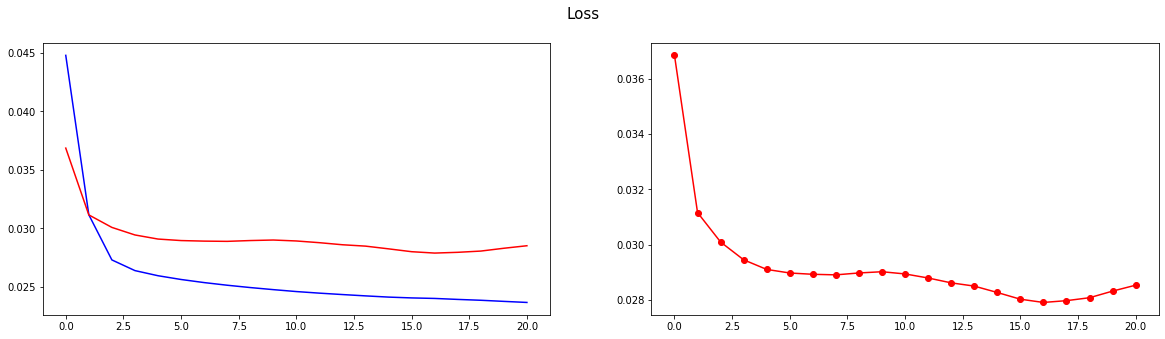

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax0 = ax[0]
ax0.plot(train_loss_list, c= 'blue')
ax0.plot(valid_loss_list, c='red')

ax1 = ax[1]
ax1.plot(valid_loss_list, c='red', marker='o')

fig.suptitle("Loss", fontsize=15)
plt.savefig(result_folder+'dr_loss.png')

### Performance Evaluation

In [18]:
checkpoint = torch.load(result_folder + 'dr-pred-traffic-best.pt')
model.load_state_dict(checkpoint['model_state_dict']) #, strict=False)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
criterion = checkpoint['criterion']
print(checkpoint['epoch'])

16


In [19]:
data = loader
model = model.eval()
test_loss = []
answers = []
predictions = []

X_test = data.test[0]
Y_test = data.test[1]

with torch.no_grad():
    for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
        x = x.to(device).transpose(1,2)
        y = y.to(device).squeeze()

        outputs = model(x)

        scale = data.scale.expand(outputs.size(0), data.m).squeeze()
        bias = data.bias.expand(outputs.size(0), data.m).squeeze()

        loss = criterion(outputs*scale+bias, y*scale+bias)
        
        answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
        predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
        test_loss.append(loss.item())  
        
test_loss = np.mean(test_loss)
print(f'test loss: {test_loss}')

0it [00:00, ?it/s]

test loss: 0.0009785530273802578


In [20]:
result_ans = pd.DataFrame(answers)
result_pred = pd.DataFrame(predictions)

result_ans.to_csv(result_folder + 'result_ans.csv')
result_pred.to_csv(result_folder + 'result_pred.csv')

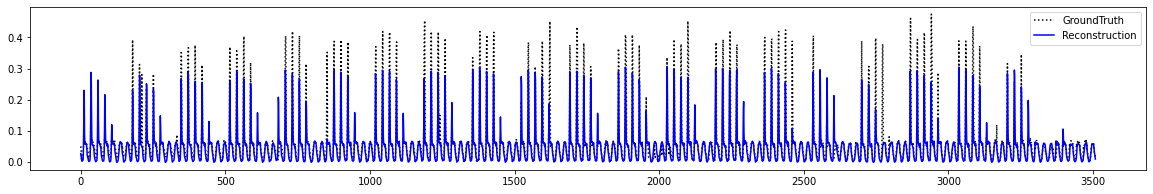

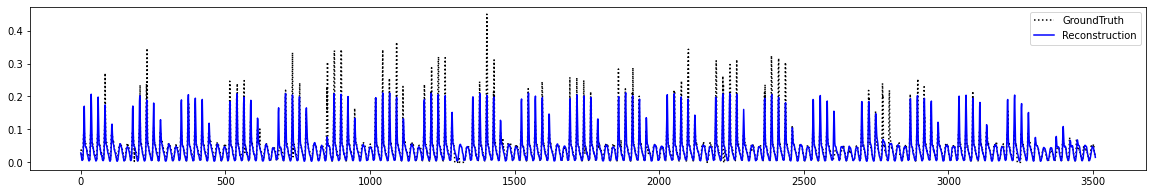

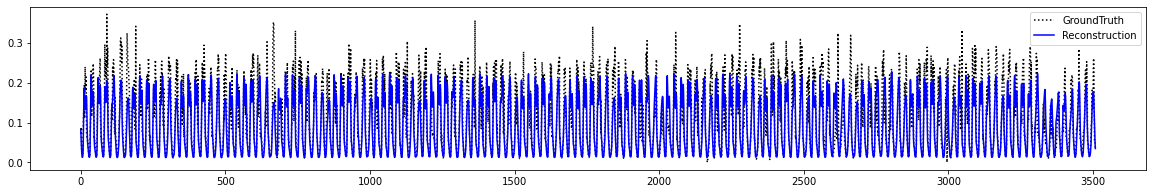

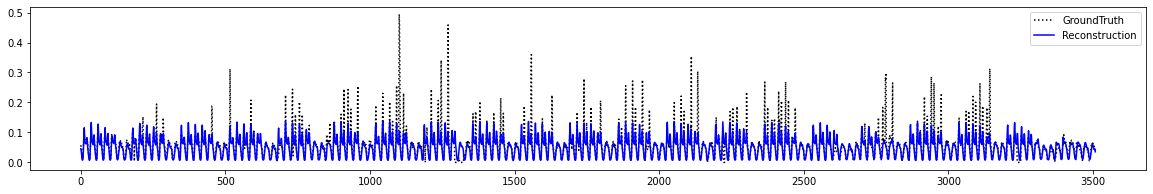

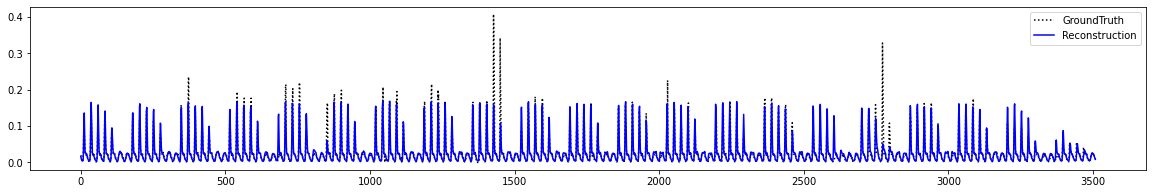

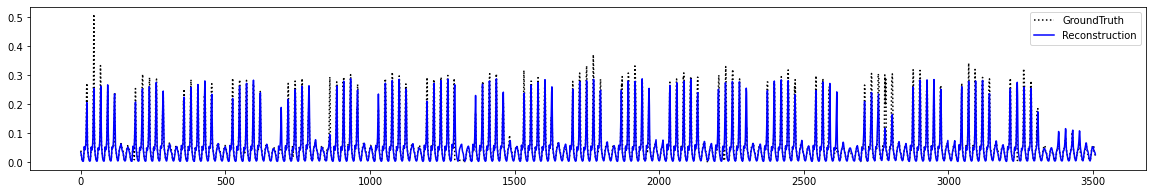

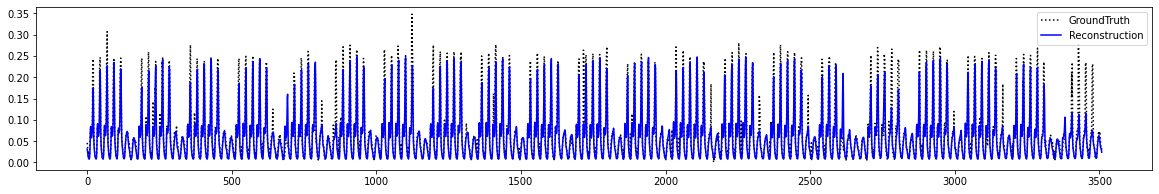

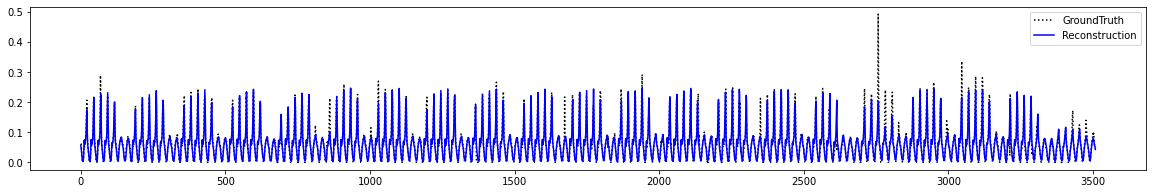

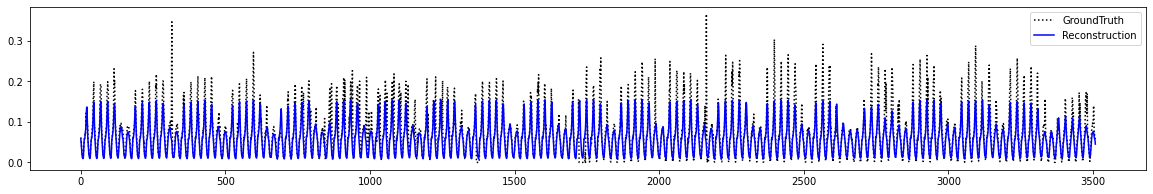

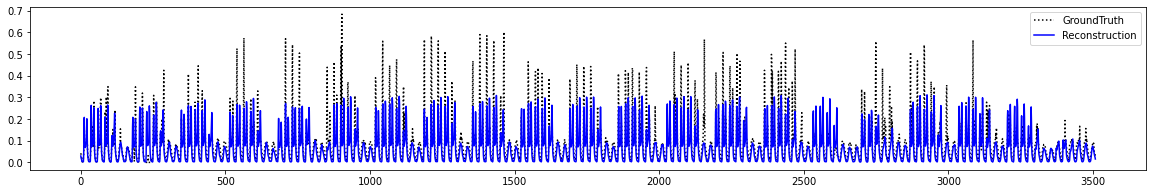

In [21]:
for i in range(10):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[:, i], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_pred.iloc[:, i], c='blue', label='Reconstruction')
    plt.legend()
    plt.show()

## Manual Attack

In [33]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    X_test, Y_test = test_loader
    
    test_loss = []
    predictions = []
    answers = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
            x = x.to(device).transpose(1,2)
            y = y.to(device)

            outputs = model(x)
            
            outputs = outputs.squeeze()
            y = y.squeeze()

            scale = data.scale.expand(outputs.size(0), data.m)
            bias = data.bias.expand(outputs.size(0), data.m)

            loss = criterion(outputs*scale+bias, y*scale+bias)

            answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
            predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
            test_loss.append(loss.item())  

    test_loss = np.mean(test_loss)
    return answers, predictions

In [34]:
def np_mse(A, B):
    return (np.square(A - B)).mean()

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

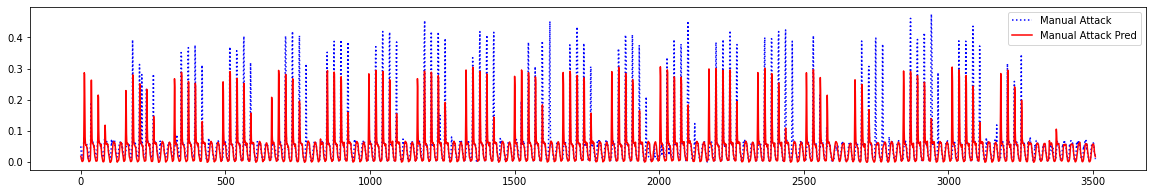

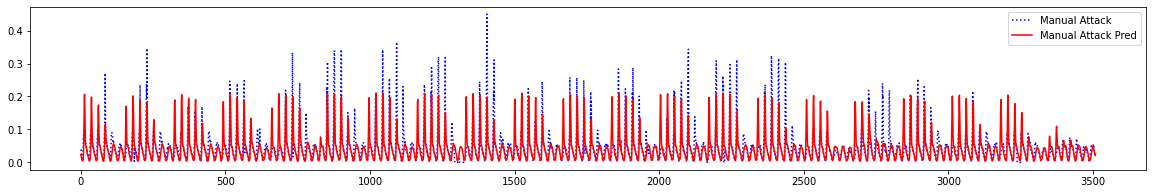

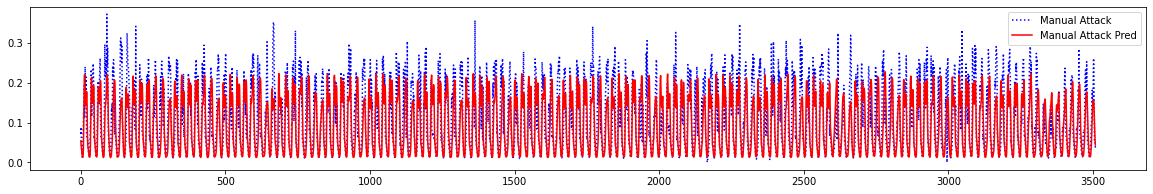

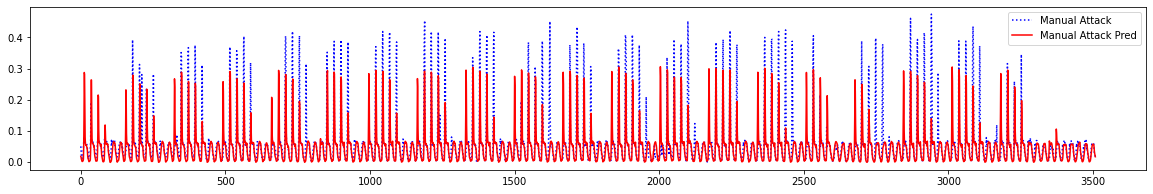

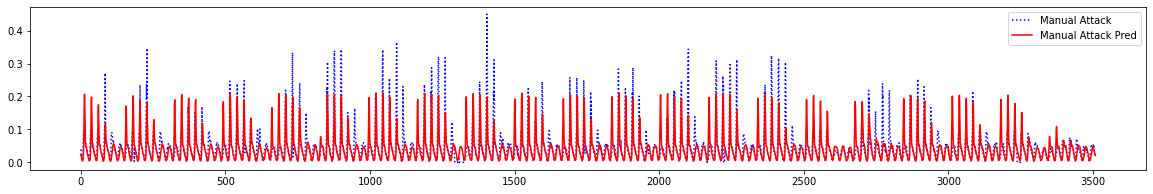

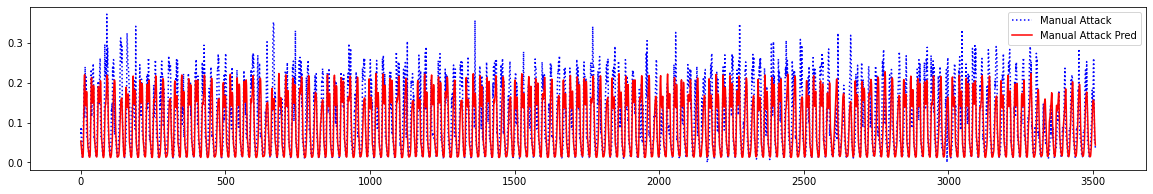

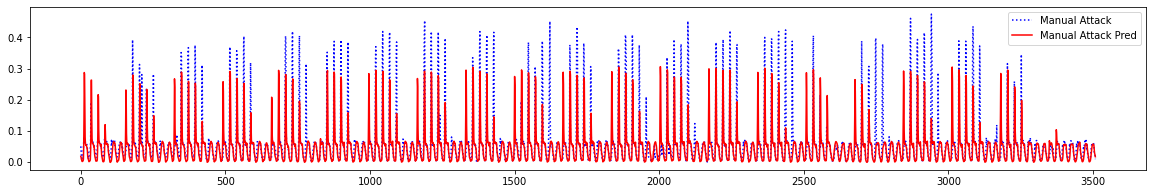

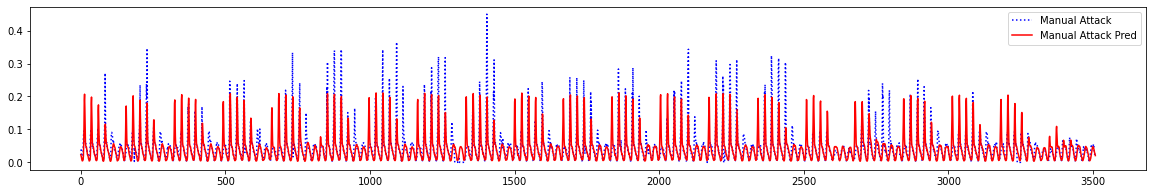

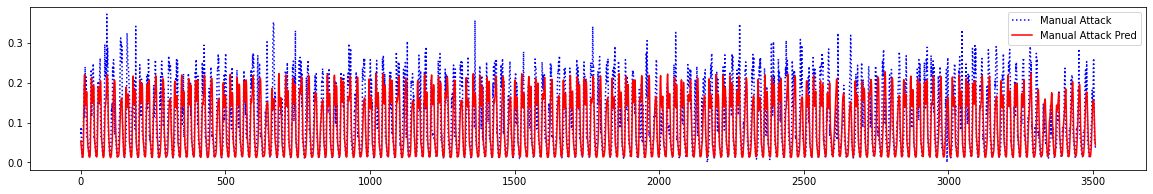

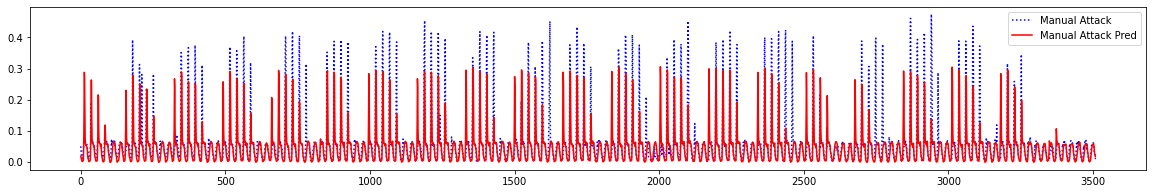

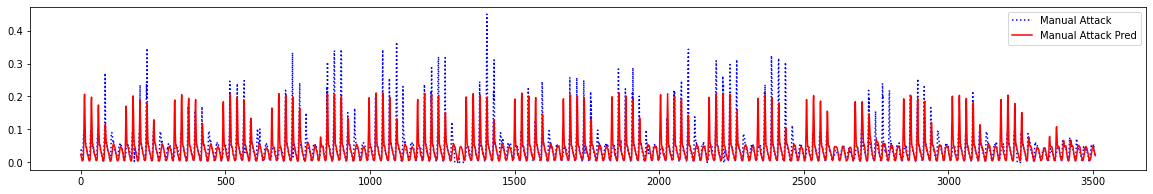

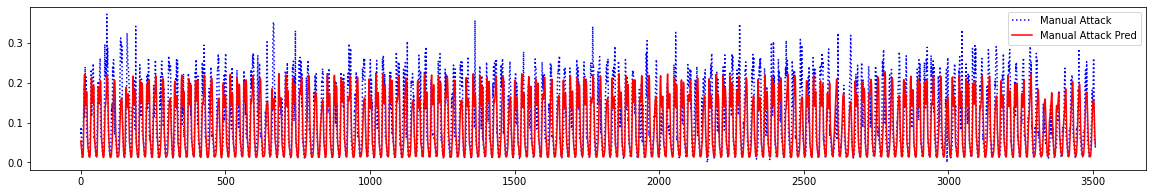

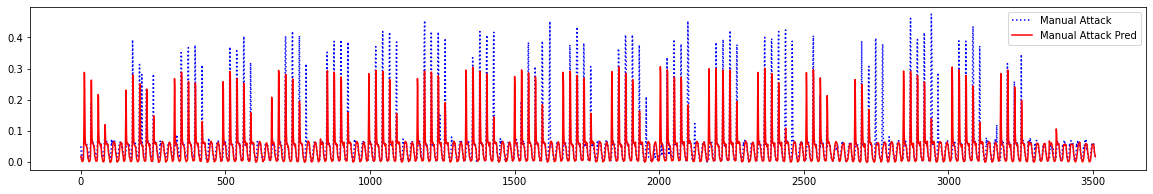

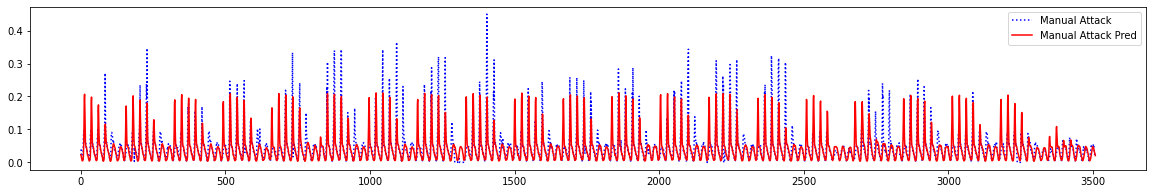

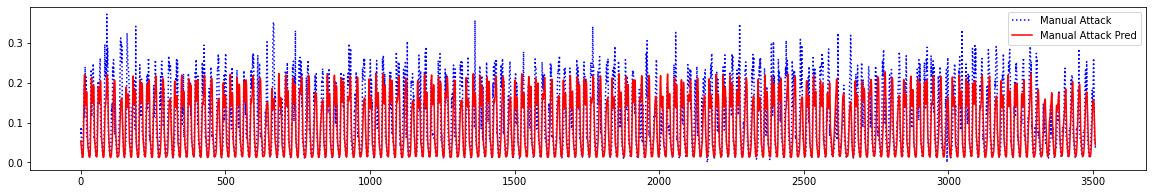

In [35]:
import pickle 
data = loader
X_test = data.test[0].to(device)
Y_test = data.test[1].to(device)
for attack in ['offset', 'increase', 'decrease', 'backward', 'forward']:
    with open(data_folder+f'traffic_{attack}Attack.pkl', 'rb') as f:
        data_ = pickle.load(f)
    X_test_attack = data_['data'].to(device)
    
    attack_loader = [X_test_attack, Y_test]
        
    answers, predictions = attack_inference(model,attack_loader, attack)
    print(attack, np.sqrt(np_mse(result_ans.values, predictions)))
    result_ans_attack = pd.DataFrame(answers)
    result_ans_attack.to_csv(result_folder + f'cnndr_{attack}_prediction.csv')
    result_pred_attack = pd.DataFrame(predictions)
    result_pred_attack.to_csv(attack_result_folder + f'cnndr_{attack}_prediction_pred.csv')
    
    for i in range(3):
        plt.figure(figsize=(20,3))
        plt.plot(result_ans.iloc[:, i], c='black', ls=':', label = 'GroundTruth')
        plt.plot(result_ans_attack.iloc[:, i], c='blue', ls=':', label='Manual Attack')
        plt.plot(result_pred_attack.iloc[:, i], c='red', label='Manual Attack Pred')
        plt.legend()
        plt.savefig(attack_result_folder + f'{attack}_sample{i}_predresult.png')

## Black Box Attack - fgsm ##

In [25]:
def fgsm_attack(model, criterion, x, y, eps, device) :
    x = x.to(device).transpose(1,2)
    y = y.to(device)
    x.requires_grad = True
            
    outputs = model(x).squeeze()
    
    model.zero_grad()
    
    scale = data.scale.expand(outputs.size(0), data.m)
    bias = data.bias.expand(outputs.size(0), data.m)
        
    cost = criterion(outputs*scale+bias, (y*scale+bias).squeeze()).to(device)
    cost.backward()
    
    attack_x = x + eps * x.grad.sign()    
    return attack_x

In [26]:
fgsm_x = []
for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
    attack_x = fgsm_attack(model, criterion, x, y, 0.1, device)
    fgsm_x.append(attack_x)
fgsm_x = torch.cat(fgsm_x, dim=0)
fgsm_test_loader = [fgsm_x, Y_test]

0it [00:00, ?it/s]

In [37]:
def attack_inference(model, test_loader, attack):
    model = model.eval()
    X_test, Y_test = test_loader
    
    test_loss = []
    predictions = []
    answers = []
    with torch.no_grad():
        for (x, y) in tqdm(data.get_batches(X_test, Y_test, 64, False), leave=False):
            x = x.to(device)
            y = y.to(device)

            outputs = model(x)
            
            outputs = outputs.squeeze()
            y = y.squeeze()

            scale = data.scale.expand(outputs.size(0), data.m)
            bias = data.bias.expand(outputs.size(0), data.m)

            loss = criterion(outputs*scale+bias, y*scale+bias)

            answers.extend((y*scale+bias).squeeze().detach().cpu().numpy())
            predictions.extend((outputs*scale+bias).squeeze().detach().cpu().numpy())
            test_loss.append(loss.item())  

    test_loss = np.mean(test_loss)
    return answers, predictions

0it [00:00, ?it/s]

fgsm 0.057647564


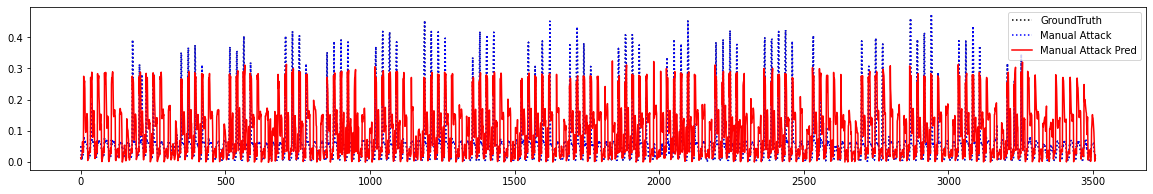

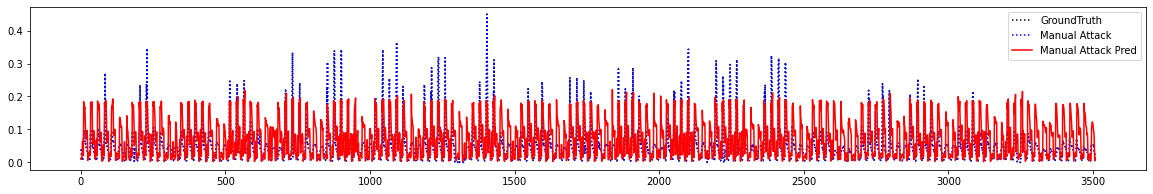

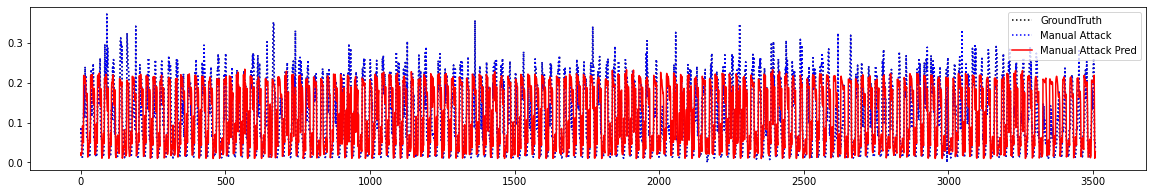

In [38]:
attack = 'fgsm'
answers, predictions = attack_inference(model,fgsm_test_loader, attack)
print(attack, np.sqrt(np_mse(result_ans.values, predictions)))
result_ans_attack = pd.DataFrame(answers)
#result_ans_attack.to_csv(result_folder + f'{attack}_prediction.csv')
result_pred_attack = pd.DataFrame(predictions)
#result_pred_attack.to_csv(attack_result_folder + f'{attack}_prediction_pred.csv')
    
for i in range(3):
    plt.figure(figsize=(20,3))
    plt.plot(result_ans.iloc[:, i], c='black', ls=':', label = 'GroundTruth')
    plt.plot(result_ans_attack.iloc[:, i], c='blue', ls=':', label='Manual Attack')
    plt.plot(result_pred_attack.iloc[:, i], c='red', label='Manual Attack Pred')
    plt.legend()
    plt.savefig(attack_result_folder + f'{attack}_sample{i}_predresult.png')